# Analyzing an initial dataset
We are starting with an archive of the datascience stackexchange questions. Let's quckly walk through the dataset. First, we will load the data.

Before being able to load the csv, make sure you have pre-processed the raw xml using our python package.

In [1]:
import json

from tqdm import tqdm
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ElT
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

df = pd.DataFrame.from_csv('data/writers.csv')


/Users/emmanuel.ameisen/ml_editor/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  del sys.path[0]
/Users/emmanuel.ameisen/ml_editor/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


## Data format

We transformed our data from xml to structured csv. 

How are we going to structure it in order to have labels for our model?

We need to measure the quality of a question. For that, we could:
- Use the number of upvotes a question gets
- Use the number of answers a question gets, or whether they get an answer at all
- Use whether an answer was marked as accepted or not

Let's look at each potential category, and their tradeoffs.

In [2]:
# How many questions do we have
# How many questions have answers, and how many answers per question on avg

df['AnswerCount'] = df['AnswerCount'].fillna(-1)
df["AnswerCount"] = df["AnswerCount"].astype(int)

df['PostTypeId'] = df['PostTypeId'].astype(int)
df['Id'] = df['Id'].astype(int)

df['is_question'] = df['PostTypeId'] == 1
df.set_index("Id", inplace=True, drop=False)

In [3]:
# About 25% of questions are unanswered, if we 
df[df['is_question']]["AnswerCount"].value_counts(normalize=True, sort=True)

1     0.239493
2     0.233346
3     0.177268
4     0.114917
5     0.079162
6     0.045164
7     0.032116
8     0.019069
0     0.018065
9     0.011918
10    0.009660
11    0.005144
12    0.004265
13    0.002635
14    0.002258
15    0.001380
16    0.001004
17    0.001004
21    0.000502
25    0.000376
19    0.000376
22    0.000251
24    0.000125
20    0.000125
41    0.000125
18    0.000125
23    0.000125
Name: AnswerCount, dtype: float64

## Data quality

- How much of the data is missing?
- What is the quality of the text?
- Do the answers match the questions?

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34330 entries, 1 to 42885
Data columns (total 25 columns):
AcceptedAnswerId         4124 non-null float64
AnswerCount              34330 non-null int64
Body                     34256 non-null object
ClosedDate               969 non-null object
CommentCount             34330 non-null int64
CommunityOwnedDate       186 non-null object
CreationDate             34330 non-null object
FavoriteCount            3307 non-null float64
Id                       34330 non-null int64
LastActivityDate         34330 non-null object
LastEditDate             11201 non-null object
LastEditorDisplayName    614 non-null object
LastEditorUserId         10648 non-null float64
OwnerDisplayName         1976 non-null object
OwnerUserId              32792 non-null float64
ParentId                 25679 non-null float64
PostTypeId               34330 non-null int64
Score                    34330 non-null int64
Tags                     7971 non-null object
Title   

We have a little over 31.000 questions. Why is the body sometimes null? 

In [5]:
df[df["Body"].isna()]

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,ParentId,PostTypeId,Score,Tags,Title,ViewCount,body_text,text_len,tokenized,is_question
Id,,,,,,,,,,,,,,,,,,,,,
2145,NaN,-1,NaN,NaN,0,NaN,2011-03-22T19:49:56.600,NaN,2145,2011-03-22T19:49:56.600,...,NaN,5,0,NaN,NaN,NaN,NaN,0,[],False
2147,NaN,-1,NaN,NaN,0,NaN,2011-03-22T19:51:05.897,NaN,2147,2011-03-22T19:51:05.897,...,NaN,5,0,NaN,NaN,NaN,NaN,0,[],False
2215,NaN,-1,NaN,NaN,0,NaN,2011-03-24T19:35:10.353,NaN,2215,2011-03-24T19:35:10.353,...,NaN,5,0,NaN,NaN,NaN,NaN,0,[],False
2218,NaN,-1,NaN,NaN,0,NaN,2011-03-24T19:41:38.677,NaN,2218,2011-03-24T19:41:38.677,...,NaN,5,0,NaN,NaN,NaN,NaN,0,[],False
2225,NaN,-1,NaN,NaN,0,NaN,2011-03-24T19:58:59.833,NaN,2225,2011-03-24T19:58:59.833,...,NaN,5,0,NaN,NaN,NaN,NaN,0,[],False
2227,NaN,-1,NaN,NaN,0,NaN,2011-03-24T20:05:07.753,NaN,2227,2011-03-24T20:05:07.753,...,NaN,5,0,NaN,NaN,NaN,NaN,0,[],False
2233,NaN,-1,NaN,NaN,0,NaN,2011-03-24T20:22:44.603,NaN,2233,2011-03-24T20:22:44.603,...,NaN,5,0,NaN,NaN,NaN,NaN,0,[],False
2238,NaN,-1,NaN,NaN,0,NaN,2011-03-24T20:38:42.200,NaN,2238,2011-03-24T20:38:42.200,...,NaN,5,0,NaN,NaN,NaN,NaN,0,[],False
3138,NaN,-1,NaN,NaN,0,NaN,2011-06-19T20:18:13.253,NaN,3138,2011-06-19T20:18:13.253,...,NaN,5,0,NaN,NaN,NaN,NaN,0,[],False


All of the null bodys are of  PostTypeId 4 or 5. The readme file only mentions PostTypeIds of 1 (questions) and 2 (answers). There are 304 rows marked 3 or 4, which we will remove since we do not know what they correspond to.

In [6]:
df[~(df["PostTypeId"].isin([1,2]))]

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,ParentId,PostTypeId,Score,Tags,Title,ViewCount,body_text,text_len,tokenized,is_question
Id,,,,,,,,,,,,,,,,,,,,,
1024,NaN,-1,<p>Anyone who hasn't been to any Stack Exchang...,NaN,0,NaN,2011-01-04T22:49:12.333,NaN,1024,2013-04-30T15:48:37.273,...,NaN,7,0,NaN,NaN,NaN,Anyone who hasn't been to any Stack Exchange s...,594,"[['Anyone', 'who', 'has', ""n't"", 'been', 'to',...",False
1885,NaN,-1,"<p>""Technique"" is literally a method, a way of...",NaN,0,NaN,2011-03-06T06:10:34.393,NaN,1885,2011-03-06T18:52:42.467,...,NaN,5,0,NaN,NaN,NaN,"""Technique"" is literally a method, a way of do...",229,"[['``', 'Technique', ""''"", 'is', 'literally', ...",False
1886,NaN,-1,"Common, repeatable methods of achieving partic...",NaN,0,NaN,2011-03-06T06:10:34.393,NaN,1886,2011-03-06T18:52:54.730,...,NaN,4,0,NaN,NaN,NaN,"Common, repeatable methods of achieving partic...",15,"[['Common', ',', 'repeatable', 'methods', 'of'...",False
1987,NaN,-1,<h2>Critique Guidelines</h2>\n\n<p>Critique re...,NaN,0,NaN,2011-03-14T17:35:34.010,NaN,1987,2012-05-01T03:56:24.657,...,NaN,5,0,NaN,NaN,NaN,Critique Guidelines\nCritique requests are ext...,185,"[['Critique', 'Guidelines', 'Critique', 'reque...",False
1988,NaN,-1,TAG IS SOON TO BE DEPRECIATED. Please use tags...,NaN,0,NaN,2011-03-14T17:35:34.010,NaN,1988,2012-05-01T19:26:10.927,...,NaN,4,0,NaN,NaN,NaN,TAG IS SOON TO BE DEPRECIATED. Please use tags...,25,"[['TAG', 'IS', 'SOON', 'TO', 'BE', 'DEPRECIATE...",False
2141,NaN,-1,"<p>This tag is not in use, due to its ambiguou...",NaN,0,NaN,2011-03-22T19:14:57.783,NaN,2141,2011-03-22T19:16:17.910,...,NaN,3,0,NaN,NaN,NaN,"This tag is not in use, due to its ambiguous n...",93,"[['This', 'tag', 'is', 'not', 'in', 'use', ','...",False
2142,NaN,-1,"This tag is not in use, due to its ambiguous n...",NaN,0,NaN,2011-03-22T19:14:57.783,NaN,2142,2011-03-22T19:16:18.940,...,NaN,3,0,NaN,NaN,NaN,"This tag is not in use, due to its ambiguous n...",35,"[['This', 'tag', 'is', 'not', 'in', 'use', ','...",False
2145,NaN,-1,NaN,NaN,0,NaN,2011-03-22T19:49:56.600,NaN,2145,2011-03-22T19:49:56.600,...,NaN,5,0,NaN,NaN,NaN,NaN,0,[],False
2146,NaN,-1,Citations are references to published or unpub...,NaN,0,NaN,2011-03-22T19:49:56.600,NaN,2146,2011-03-22T19:49:56.600,...,NaN,4,0,NaN,NaN,NaN,Citations are references to published or unpub...,37,"[['Citations', 'are', 'references', 'to', 'pub...",False


In [7]:
# Filtering out PostTypeIds other than documented ones
df = df[df["PostTypeId"].isin([1,2])]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33650 entries, 1 to 42885
Data columns (total 25 columns):
AcceptedAnswerId         4124 non-null float64
AnswerCount              33650 non-null int64
Body                     33650 non-null object
ClosedDate               969 non-null object
CommentCount             33650 non-null int64
CommunityOwnedDate       186 non-null object
CreationDate             33650 non-null object
FavoriteCount            3307 non-null float64
Id                       33650 non-null int64
LastActivityDate         33650 non-null object
LastEditDate             10521 non-null object
LastEditorDisplayName    606 non-null object
LastEditorUserId         9975 non-null float64
OwnerDisplayName         1971 non-null object
OwnerUserId              32117 non-null float64
ParentId                 25679 non-null float64
PostTypeId               33650 non-null int64
Score                    33650 non-null int64
Tags                     7971 non-null object
Title    

Now let's look at questions and accepted answers and see if they match!

In [9]:
questions_with_accepted_answers = df[df["is_question"] & ~(df["AcceptedAnswerId"].isna())]
q_and_a = questions_with_accepted_answers.join(df[["body_text"]], on='AcceptedAnswerId', how='left', rsuffix="_answer")

pd.options.display.max_colwidth = 500
q_and_a[["body_text", "body_text_answer"]][:5]

,body_text,body_text_answer
Id,,
1,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n","When I'm thinking about where I learned most how to write, I think that reading was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I need when re..."
2,"What kind of story is better suited for each point of view? Are there advantages or disadvantages inherent to them?\nFor example, writing in the first person you are always following a character, while in the third person you can ""jump"" between story lines.\n","With a story in first person, you are intending the reader to become much more attached to the main character. Since the reader sees what that character sees and feels what that character feels, the reader will have an emotional investment in that character. Third person does not have this close tie; a reader can become emotionally invested but it will not be as strong as it will be in first person.\nContrarily, you cannot have multiple point characters when you use first person without ex..."
3,"I finished my novel, and everyone I've talked to says I need an agent. How do I find one?\n","Try and find a list of agents who write in your genre. Check out their websites!\nFind out if they are accepting new clients. If they aren't, then check out another agent. But if they are, try sending them a few chapters from your story, a brief, and a short cover letter asking them to represent you.\nIn the cover letter mention your previous publication credits. If sent via post, then I suggest you give them a means of reply, whether it be an email or a stamped, addressed envelope.\nAgents ..."
7,"I keep hearing about literary fiction, and how it is so much better than genre fiction. What exactly is literary fiction?\n","There's always the good old wikipedia definition: http://en.wikipedia.org/wiki/Literary_fiction\nMy take on it is that it is often used to mean ""serious"" fiction (whatever that is), as opposed to fiction that is merely ""entertainment"". It often seems to be thrown about in the context of snobbery (that is, someone may not ""read that airport bookshop rubbish"" because they like literary fiction), but I don't know if people really say those sorts of things, or if it's just the impression that th..."
11,I heard a writer talking about pantsing a story. What does that mean?\n,"""Pantsing"" refers to simply writing a story without much, if any, preparation or pre-writing -- just writing down whatever comes to you, and letting the story go (and wander) wherever it feels like at the moment you're writing it down.\nAs for etymology, I'm not sure where it comes from. In general, ""pantsing"" refers to a prank in which you pull someone's pants down, but I'm not sure how that plays into the idea of writing (aside from the fact that both can be surprising).\n"


So far so good, and the text seems good except for potentially unescaped newlines characters ("\n")

In [10]:
df[["body_text", "ParentId"]]

,body_text,ParentId
Id,,
1,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n",NaN
2,"What kind of story is better suited for each point of view? Are there advantages or disadvantages inherent to them?\nFor example, writing in the first person you are always following a character, while in the third person you can ""jump"" between story lines.\n",NaN
3,"I finished my novel, and everyone I've talked to says I need an agent. How do I find one?\n",NaN
5,"When writing a short-story to highlight a certain truth, is it typically a better practice to construct a point to exemplify through the short-story?\nIn other words, construct the characters, plot and setting based on the point I want to portray, instead of focusing on plot first.\nAlthough, I need to make sure the plot is engaging.\nIs this a good practice?\n",NaN
7,"I keep hearing about literary fiction, and how it is so much better than genre fiction. What exactly is literary fiction?\n",NaN
8,BeginningWriters.com has some good articles for beginning writers.\nhttp://beginningwriters.com/\n,1.0
9,"Whenever I attempt to write something, I do it in a common word processor (like Microsoft Word), but I was wondering if there is a special software for it.\nSomething that would help me keep track of the story lines, times, and characters in an easy and organized way as to not get lost in my own story\n",NaN
10,"If you have a point that you do want to convey, this is certainly a legitimate practice. You shouldn't make artificial points just to have them, however.\nIt is important to ensure that your point does not become too contrived, as well. There are cases where everything should be a microcosm of your main theme, but they are rare, even in a short story. You do need to have a strong plot and characters and setting as well. The point will be lost if the writing falters because of it.\nMany s...",5.0
11,I heard a writer talking about pantsing a story. What does that mean?\n,NaN


In [11]:
print(df.index)

Int64Index([    1,     2,     3,     5,     7,     8,     9,    10,    11,
               14,
            ...
            42876, 42877, 42878, 42879, 42880, 42881, 42882, 42883, 42884,
            42885],
           dtype='int64', name='Id', length=33650)


In [12]:
# Linking questions and answers
# df["id"] = df.index
# to_join = df[["Id", "Title", "body_text", "text_len", "Score", "AcceptedAnswerId"]]
# print(to_join.index)
df = df.join(df[["Id", "Title", "body_text", "text_len", "Score", "AcceptedAnswerId"]], on='ParentId', how='left', rsuffix='_question')


In [13]:
df

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,body_text,text_len,tokenized,is_question,Id_question,Title_question,body_text_question,text_len_question,Score_question,AcceptedAnswerId_question
Id,,,,,,,,,,,,,,,,,,,,,
1,15.0,9,"<p>I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.</p>\n\n<p>Are there some resources on how to start becoming a writer?</p>\n\n<p>I'm thinking something with tips and easy exercises to get the ball rolling.</p>\n",NaN,7,NaN,2010-11-18T20:40:32.857,17.0,1,2019-02-10T04:06:33.283,...,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n",61,"[['I', ""'ve"", 'always', 'wanted', 'to', 'start', 'writing', '(', 'in', 'a', 'totally', 'amateur', 'way', ')', ',', 'but', 'whenever', 'I', 'want', 'to', 'start', 'something', 'I', 'instantly', 'get', 'blocked', 'having', 'a', 'lot', 'of', 'questions', 'and', 'doubts', '.'], ['Are', 'there', 'some', 'resources', 'on', 'how', 'to', 'start', 'becoming', 'a', 'writer', '?'], ['I', ""'m"", 'thinking', 'something', 'with', 'tips', 'and', 'easy', 'exercises', 'to', 'get', 'the', 'ball', 'rolling', '.']]",True,NaN,NaN,NaN,NaN,NaN,NaN
2,16.0,7,"<p>What kind of story is better suited for each point of view? Are there advantages or disadvantages inherent to them?</p>\n\n<p>For example, writing in the first person you are always <em>following</em> a character, while in the third person you can ""jump"" between story lines.</p>\n",NaN,0,NaN,2010-11-18T20:42:31.513,5.0,2,2018-04-29T19:35:55.850,...,"What kind of story is better suited for each point of view? Are there advantages or disadvantages inherent to them?\nFor example, writing in the first person you are always following a character, while in the third person you can ""jump"" between story lines.\n",51,"[['What', 'kind', 'of', 'story', 'is', 'better', 'suited', 'for', 'each', 'point', 'of', 'view', '?'], ['Are', 'there', 'advantages', 'or', 'disadvantages', 'inherent', 'to', 'them', '?'], ['For', 'example', ',', 'writing', 'in', 'the', 'first', 'person', 'you', 'are', 'always', 'following', 'a', 'character', ',', 'while', 'in', 'the', 'third', 'person', 'you', 'can', '``', 'jump', ""''"", 'between', 'story', 'lines', '.']]",True,NaN,NaN,NaN,NaN,NaN,NaN
3,31.0,5,"<p>I finished my novel, and everyone I've talked to says I need an agent. How do I find one?</p>\n",NaN,1,NaN,2010-11-18T20:43:28.903,10.0,3,2018-05-04T11:04:09.610,...,"I finished my novel, and everyone I've talked to says I need an agent. How do I find one?\n",23,"[['I', 'finished', 'my', 'novel', ',', 'and', 'everyone', 'I', ""'ve"", 'talked', 'to', 'says', 'I', 'need', 'an', 'agent', '.'], ['How', 'do', 'I', 'find', 'one', '?']]",True,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,7,"<p>When writing a short-story to highlight a certain truth, is it typically a better practice to construct a point to exemplify through the short-story?</p>\n\n<p>In other words, construct the characters, plot and setting based on the point I want to portray, instead of focusing on plot first.</p>\n\n<p>Although, I need to make sure the plot is engaging.</p>\n\n<p>Is this a good practice?</p>\n",NaN,0,NaN,2010-11-18T20:43:59.693,4.0,5,2018-04-29T19:29:44.710,...,"When writing a short-story to highlight a certain truth, is it typically a better practice to construct a point to exemplify through the short-story?\nIn other words, construct the characters, plot and setting based on the point I want to portray, instead of focusing on plot first.\nAlthough, I need to make sure the plot is engaging.\nIs this a good practice?\n",71,"[['When', 'writing', 'a', 'sh

In [14]:
df[df["Id_question"] ==1]

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,body_text,text_len,tokenized,is_question,Id_question,Title_question,body_text_question,text_len_question,Score_question,AcceptedAnswerId_question
Id,,,,,,,,,,,,,,,,,,,,,
8,NaN,-1,"<p>BeginningWriters.com has some good articles for beginning writers.</p>\n\n<p><a href=""http://beginningwriters.com/"">http://beginningwriters.com/</a></p>\n",NaN,0,NaN,2010-11-18T20:45:45.533,NaN,8,2010-11-18T20:45:45.533,...,BeginningWriters.com has some good articles for beginning writers.\nhttp://beginningwriters.com/\n,12,"[['BeginningWriters.com', 'has', 'some', 'good', 'articles', 'for', 'beginning', 'writers', '.'], ['http', ':', '//beginningwriters.com/']]",False,1.0,What are some online guides for starting writers?,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n",61.0,32.0,15.0
15,NaN,-1,"<p>When I'm thinking about where I learned most how to write, I think that <em>reading</em> was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I ...",NaN,3,NaN,2010-11-18T20:50:16.683,NaN,15,2010-11-18T21:04:08.450,...,"When I'm thinking about where I learned most how to write, I think that reading was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I need when re...",200,"[['When', 'I', ""'m"", 'thinking', 'about', 'where', 'I', 'learned', 'most', 'how', 'to', 'write', ',', 'I', 'think', 'that', 'reading', 'was', 'the', 'most', 'important', 'guide', 'to', 'me', '.'], ['This', 'may', 'sound', 'silly', ',', 'but', 'by', 'reading', 'good', 'written', 'newspaper', 'articles', '(', 'facts', ',', 'opinions', ',', 'scientific', 'articles', 'and', 'most', 'of', 'all', ',', 'criticisms', 'of', 'films', 'and', 'music', ')', ',', 'I', 'learned', 'how', 'others', 'did', 't...",False,1.0,What are some online guides for starting writers?,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n",61.0,32.0,15.0
79,NaN,-1,"<p>I particularly like <a href=""http://www.advancedfictionwriting.com/art/snowflake.php"" rel=""nofollow"" rel=""nofollow"">The Snowflake Method</a> and most of what Randy writes, including his book.</p>\n",NaN,0,NaN,2010-11-18T23:19:33.157,NaN,79,2010-11-18T23:19:33.157,...,"I particularly like The Snowflake Method and most of what Randy writes, including his book.\n",17,"[['I', 'particularly', 'like', 'The', 'Snowflake', 'Method', 'and', 'most', 'of', 'what', 'Randy', 'writes', ',', 'including', 'his', 'book', '.']]",False,1.0,What are some online guides for starting writers?,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and

## Data quantity and distribution

- How many questions do we have?
- How many do we have of each class or type?

In [15]:
has_accepted_answer = df[df["is_question"] & ~(df["AcceptedAnswerId"].isna())]
no_accepted_answers = df[df["is_question"] & (df["AcceptedAnswerId"].isna()) & (df["AnswerCount"]!=0)]
no_answers = df[df["is_question"] & (df["AcceptedAnswerId"].isna()) & (df["AnswerCount"]==0)]

print("%s total questions\n%s without any answer\n%s with at least one answer\n%s with an accepted answer" % (
    len(df[df["is_question"]]),
    len(no_answers),
    len(no_accepted_answers),
    len(has_accepted_answer)))

7971 total questions
144 without any answer
3703 with at least one answer
4124 with an accepted answer


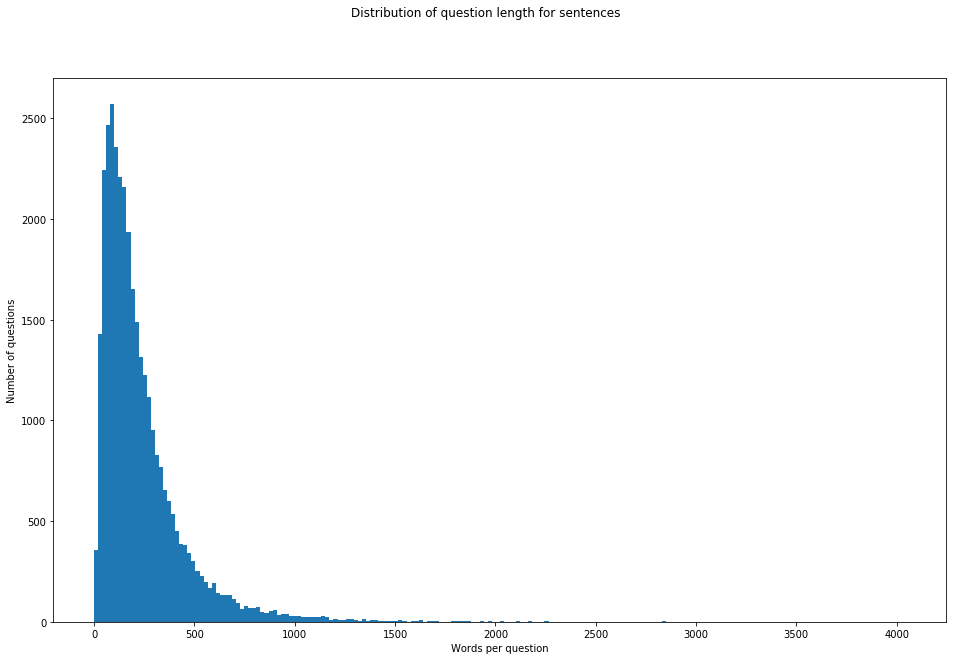

In [16]:
fig = plt.figure(figsize=(16,10))
fig.suptitle('Distribution of question length for sentences')
plt.xlabel('Words per question')
plt.ylabel('Number of questions')
q_len = plt.hist(df["text_len"],  bins=200,log=False)

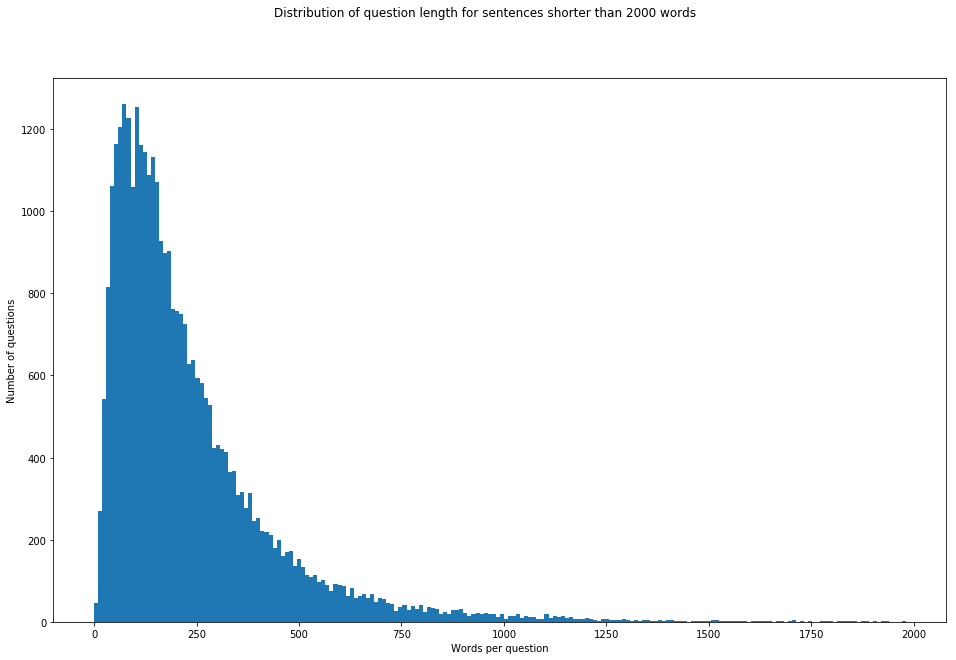

In [17]:
fig = plt.figure(figsize=(16,10))
fig.suptitle(
    'Distribution of question length for sentences shorter than 2000 words')
plt.xlabel('Words per question')
plt.ylabel('Number of questions')
q_len_trunc = plt.hist(df[df["text_len"]<2000]["text_len"], bins=200, log=False)

Text(0, 0.5, 'Percentage of sentences')

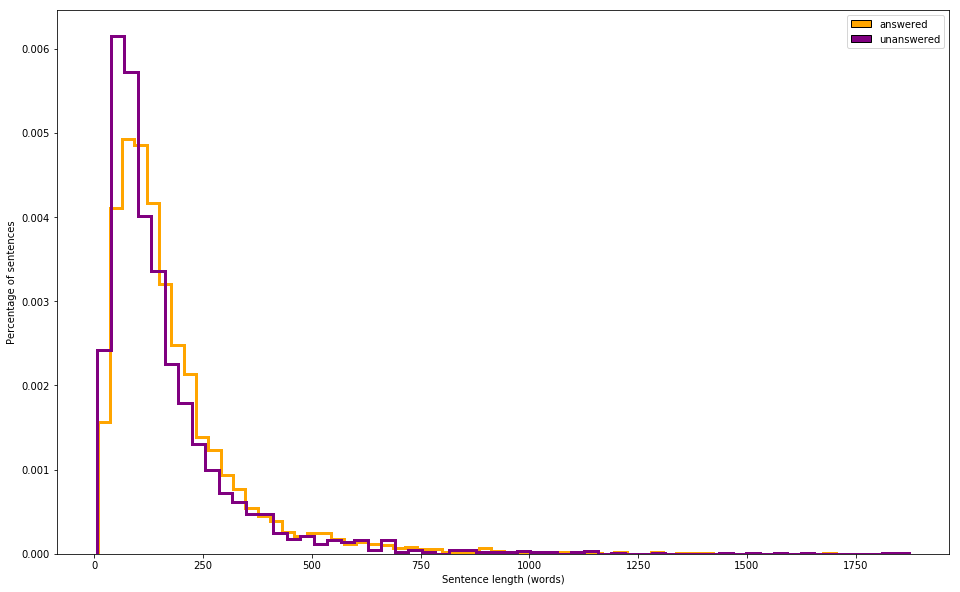

In [18]:
from matplotlib.patches import Rectangle

ax = df[df["is_question"] &
        ~(df["AcceptedAnswerId"].isna()) &
        (df["text_len"] < 2000)]["text_len"].hist(bins=60,
                                                          density=True,
                                                          histtype='step',
                                                          color='orange',
                                                          linewidth=3,
                                                          grid=False,
                                                          figsize=(16, 10))

df[df["is_question"] &
   (df["AcceptedAnswerId"].isna()) &
   (df["text_len"] < 2000)]["text_len"].hist(bins=60,
                                                     density=True,
                                                     histtype='step',
                                                     color='purple',
                                                     linewidth=3,
                                                     grid=False)

handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in
           ['orange', 'purple']]
labels = ["answered", "unanswered"]
plt.legend(handles, labels)
ax.set_xlabel("Sentence length (words)")
ax.set_ylabel("Percentage of sentences")

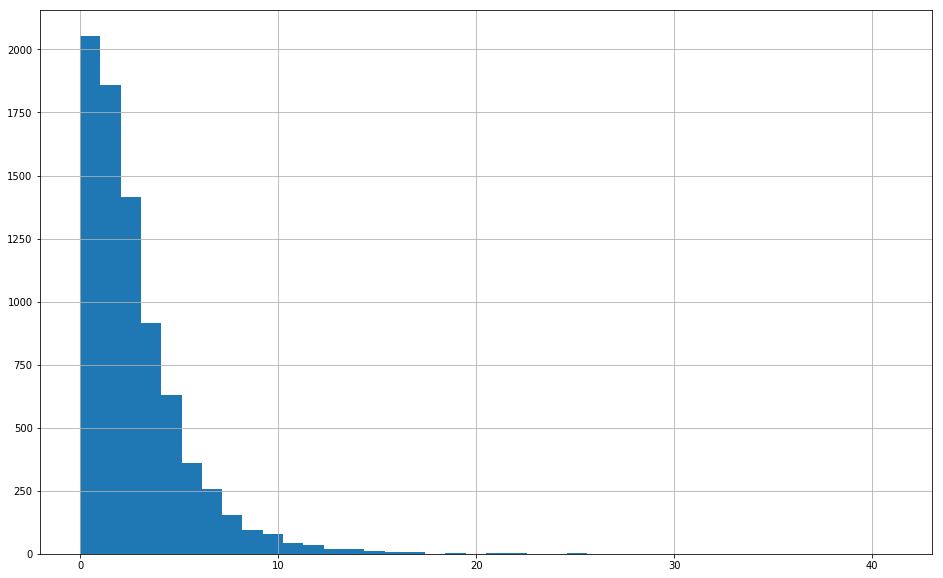

In [19]:
# Distribution of numbe rof answers
hist = df[df["is_question"]]["AnswerCount"].hist(bins=40, figsize=(16, 10))

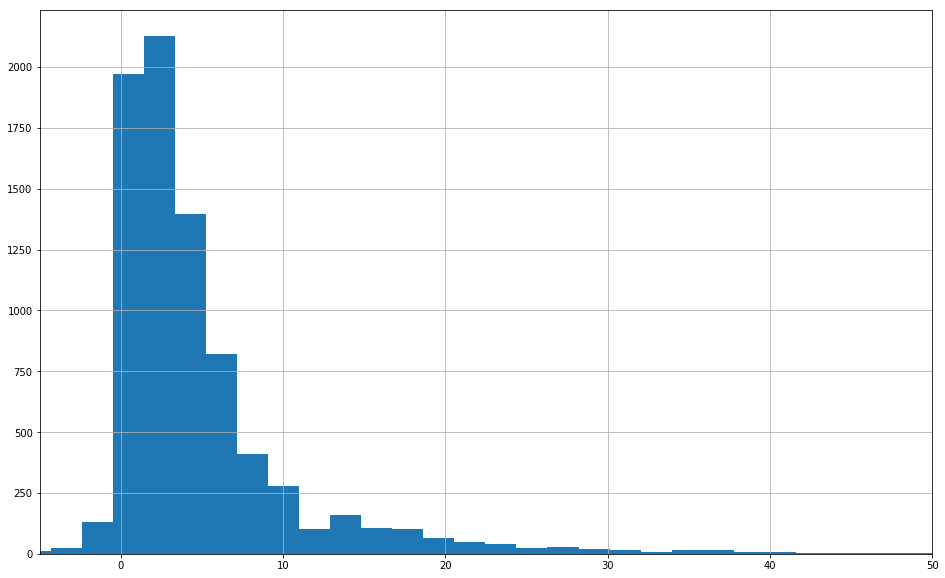

In [20]:
# Most question scores are under 10

plt.xlim(-5,50)
ax = df[df["is_question"]]["Score"].hist(bins=100, figsize=(16, 10))

Text(0, 0.5, 'Percentage of sentences')

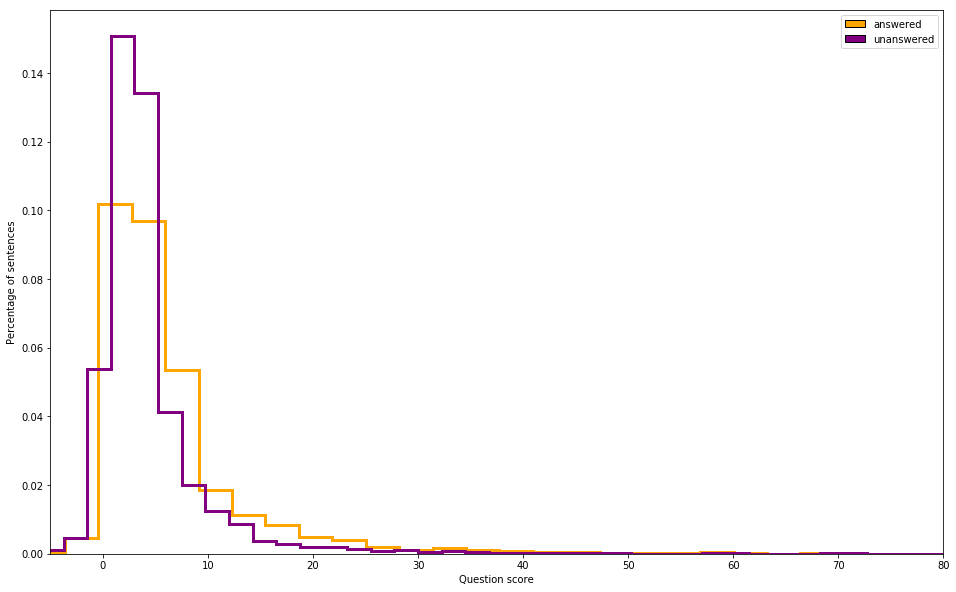

In [21]:
from matplotlib.patches import Rectangle
plt.xlim(-5,80)

ax = df[df["is_question"] &
        ~(df["AcceptedAnswerId"].isna())]["Score"].hist(bins=60,
                                                          density=True,
                                                          histtype='step',
                                                          color='orange',
                                                          linewidth=3,
                                                          grid=False,
                                                          figsize=(16, 10))

df[df["is_question"] &
   (df["AcceptedAnswerId"].isna())]["Score"].hist(bins=60,
                                                     density=True,
                                                     histtype='step',
                                                     color='purple',
                                                     linewidth=3,
                                                     grid=False)

handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in
           ['orange', 'purple']]
labels = ["answered", "unanswered"]
plt.legend(handles, labels)
ax.set_xlabel("Question score")
ax.set_ylabel("Percentage of sentences")

## Let's vectorize our data to explore it

In [26]:
tabular_df.head()

,Tags,CommentCount,CreationDate,Score,NormComment,NormScore,date,year,month,day,hour
Id,,,,,,,,,,,
1,<resources><first-time-author>,7,2010-11-18T20:40:32.857,32,0.165706,0.140501,2010-11-18 20:40:32.857,2010,11,18,20
2,<fiction><grammatical-person><third-person>,0,2010-11-18T20:42:31.513,20,-0.103524,0.077674,2010-11-18 20:42:31.513,2010,11,18,20
3,<publishing><novel><agent>,1,2010-11-18T20:43:28.903,34,-0.065063,0.150972,2010-11-18 20:43:28.903,2010,11,18,20
5,<plot><short-story><planning><brainstorming>,0,2010-11-18T20:43:59.693,28,-0.103524,0.119558,2010-11-18 20:43:59.693,2010,11,18,20
7,<fiction><genre><categories>,1,2010-11-18T20:45:44.067,21,-0.065063,0.082909,2010-11-18 20:45:44.067,2010,11,18,20


In [27]:
# Select our tags, represented as strings, and transform them into arrays of tags
tags = tabular_df["Tags"]
clean_tags = tags.str.split("><").apply(
    lambda x: [a.strip("<").strip(">") for a in x])

# Use pandas' get_dummies to get dummy values 
# select only tags that appear over 500 times
tag_columns = pd.get_dummies(clean_tags.apply(pd.Series).stack()).sum(level=0)
all_tags = tag_columns.astype(bool).sum(axis=0).sort_values(ascending=False)
top_tags = all_tags[all_tags > 500]
top_tag_columns = tag_columns[top_tags.index]


In [28]:
top_tag_columns.head()

,creative-writing,fiction,style,characters,technique,novel,publishing
Id,,,,,,,
1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,0,0,0,0,1,1
5,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0


In [29]:
# Add our tags back into our initial DataFrame
final = pd.concat([tabular_df, top_tag_columns], axis=1)

# Keeping only the vectorized features
col_to_keep = ["year", "month", "day", "hour", "NormComment",
               "NormScore"] + list(top_tags.index)
final_features = final[col_to_keep]

In [30]:
all_tags

creative-writing            1351
fiction                     1253
style                        991
characters                   609
technique                    549
novel                        531
publishing                   529
character-development        419
plot                         405
technical-writing            345
dialogue                     318
fantasy                      306
editing                      289
academic-writing             277
formatting                   273
copyright                    267
structure                    265
self-publishing              235
word-choice                  234
legal                        234
citations                    230
description                  210
short-story                  205
screenwriting                190
software                     188
non-fiction                  174
tools                        170
planning                     159
science-fiction              154
resources                    154
          

### Different ways to split data

#### Random Split

First, let's split our data randomly in train and test

In [31]:
from data_processing import format_raw_df

df = pd.DataFrame.from_csv('data/writers.csv')
df = format_raw_df(df.copy())

/Users/emmanuel.ameisen/ml_editor/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/emmanuel.ameisen/ml_editor/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [32]:
from data_processing import get_random_train_test_split, get_vectorized_inputs_and_label

train_df_rand, test_df_rand = get_random_train_test_split(df[df["is_question"]], test_size=0.2, random_state=40)

In [33]:
len(train_df_rand), len(test_df_rand)

(6376, 1595)

#### Author Split

Some authors may be more successful on average, and that may due to factors other than the quality of their formulation such as their popularity. To remove this potential source of bias, we could split by author

In [34]:
from data_processing import get_split_by_author

train_author, test_author = get_split_by_author(df[df["is_question"]])

print("%s questions in training, %s in test." % (len(train_author),len(test_author)))
train_owners = set(train_author['OwnerUserId'].values)
test_owners = set(test_author['OwnerUserId'].values)
print("%s different owners in the training set" % len(train_owners))
print("%s different owners in the testing set" % len(test_owners))
print("%s overlapping owners" % len(train_owners.intersection(test_owners)))

5676 questions in training, 2295 in test.
2723 different owners in the training set
1167 different owners in the testing set
0 overlapping owners


### Now let's vectorize our text

#### TF-IDF on ngrams

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

questions = train_author[train_author["is_question"]]
raw_text = questions["body_text"]
sent_labels = questions["AcceptedAnswerId"].notna()

sent_labels.value_counts()

True     2907
False    2769
Name: AcceptedAnswerId, dtype: int64

In [36]:
# Create an instance of a tfidf vectorizer, 
# We could use CountVectorizer for a non normalized version
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_features=2**21)

# Fit our vectorizer to questions in our dataset
# Returns an array of vectorized text
bag_of_words = vectorizer.fit_transform(raw_text)

bag_of_words.shape

(5676, 27381)

In [37]:
import umap

umap_embedder = umap.UMAP()
umap_bow = umap_embedder.fit_transform(bag_of_words)

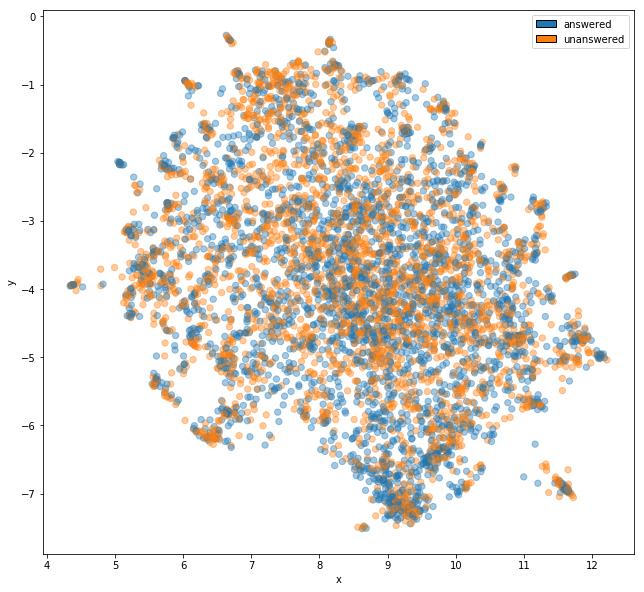

In [38]:
def plot_embeddings(embeddings):
    fig = plt.figure(figsize=(16, 10))
    color_map = {
        True: '#1f77b4',
        False:'#ff7f0e'
    }
    plt.scatter(embeddings[:, 0], embeddings[:, 1], 
                c=[color_map[x] for x in sent_labels], 
              s=40, alpha=0.4)

    handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in
               ['#1f77b4', '#ff7f0e']]
    labels = ["answered", "unanswered"]
    plt.legend(handles, labels)

    plt.gca().set_aspect('equal', 'box')
    plt.gca().set_xlabel("x")
    plt.gca().set_ylabel("y")

plot_embeddings(umap_bow)

#### Pre-trained word embeddings

In [ ]:
import spacy
import umap
import numpy as np 
# Load a large model, and disable pipeline unnecessary parts for our task
# This speeds up the vectorization process significantly
# See https://spacy.io/models/en#en_core_web_lg for details about the model
nlp = spacy.load('en_core_web_lg', disable=["parser", "tagger", "ner", "textcat"])

In [ ]:
# Get the vector for each of our questions
# By default, the vector returned is the average of all vectors in the sentence
# See https://spacy.io/usage/vectors-similarity for more
spacy_emb = train_author[train_author["is_question"]]["body_text"].apply(lambda x: nlp(x).vector)
embeddings = np.vstack(spacy_emb)

In [ ]:
# embeddings = list(spacy_emb)

umap_embedder = umap.UMAP()
umap_emb = umap_embedder.fit_transform(embeddings)

In [ ]:
plot_embeddings(umap_emb)

Initially, our different classes do not seem that well separated at all, let's go through the data and see if we can find any patterns to create a few features that could be useful.

In [ ]:
from io import BytesIO
from PIL import Image
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10, Category10

output_notebook()

def get_interactive_umap_embeddings_plot(umap_vectors, labels, text, legends, tooltip_label=None):
    if not tooltip_label:
        print("Using standard label")
        tooltip_label = labels
    w2v_df = pd.DataFrame(umap_vectors, columns=('x', 'y'))
    print(len(w2v_df))
    w2v_df['label'] = [str(x) for x in labels]
    w2v_df['tooltip_label'] = [str(x) for x in tooltip_label]
    w2v_df['text'] = list(text)
    w2v_df['legends'] = ["Answered" if el else "Unanswered" for el in list(legends)]
    datasource = ColumnDataSource(w2v_df)

    color_mapping = CategoricalColorMapper(factors=['True','False'], palette=['#1f77b4', '#ff7f0e'])

    TOOLTIPS = [
        ("text", "@text"),
        ('got_answer', '@tooltip_label')
    ]
    hover = HoverTool(tooltips=TOOLTIPS)
    hover.attachment ='right'

    plot_figure = figure(
        title='UMAP projection of questions',
        plot_width=900,
        plot_height=600,
        tools=('pan, wheel_zoom, reset', 'box_zoom', 'undo')
    )
    plot_figure.add_tools(hover)
    
    plot_figure.circle(
        'x',
        'y',
        source=datasource,
        color=dict(field='label', transform=color_mapping),
        legend='legends',
        line_alpha=0,
        fill_alpha=0.4,
        size=5
    )
    return plot_figure

# plot_figure = get_interactive_umap_embeddings_plot(umap_emb, sent_labels, raw_text, legends=sent_labels)
# show(plot_figure)

In [ ]:
df["body_text_question"].fillna("", inplace=True)

def show_question_features_containing(text):
    return df[df["body_text_question"].str.contains(text)][["body_text", "CommentCount", "text_len", 
                                                             "body_text_question", "text_len_question", 
                                                       "Score_question", "AcceptedAnswerId_question"]]

# Good example of two similar questions
show_question_features_containing("I'm an amateur writer")


## Potential features

Looking at the examples above, we can already think of a few features that could make our model better. To start with, we could generate features for:
- question length
- presence of question mark
- vocabulary associated with a clear question (action verbs, etc...)

In [ ]:
df["action_verb"] = (df["body_text"].str.contains("can", regex=False) | df["body_text"].str.contains("What", regex=False) | df["body_text"].str.contains("should", regex=False)).astype(int)
df["question_mark"] = df["body_text"].str.contains("?", regex=False)


In [ ]:
df["action_verb"].value_counts()

In [ ]:
df["question_mark"].value_counts()

In [ ]:
df["norm_text_len"]= get_normalized_series(df, "text_len")

In [ ]:
# Appending our generated features to word features

train_author, test_author = get_split_by_author(df[df["is_question"]])
vectorized_features = np.append(np.array(embeddings), train_author[train_author["is_question"]][["action_verb","question_mark", 
                                                                            "norm_text_len"]], 1)

vectorized_features.shape

In [ ]:
umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(vectorized_features)

In [ ]:
plot_embeddings(umap_features)

In [ ]:
# plot_figure = get_interactive_umap_embeddings_plot(umap_features, sent_labels, raw_text, legends=sent_labels)
# show(plot_figure)

In [ ]:
show_question_features_containing("capitalize")
show_question_features_containing("abbreviate")
show_question_features_containing("Specifically, how to describe")

# The title actually describes a lot of information
df[df["body_text"].str.contains("Specifically, how to describe", regex=False)][["body_text", "Title"]]


In [ ]:
df["language_question"] = (df["body_text"].str.contains("punctuate", regex=False) | df["body_text"].str.contains("capitalize", regex=False) | df["body_text"].str.contains("abbreviate", regex=False)).astype(int)


In [ ]:
df["full_text"] = df["Title"].str.cat(df["body_text"], sep=' ', na_rep='')

In [ ]:
df["action_verb_full"] = (df["full_text"].str.contains("can", regex=False) | df["full_text"].str.contains("What", regex=False) | df["full_text"].str.contains("should", regex=False)).astype(int)
df["question_mark_full"] = df["full_text"].str.contains("?", regex=False)


In [ ]:
from data_processing import add_features_to_df
df = add_features_to_df(df.loc[df["is_question"]].copy())

In [ ]:
from data_processing import get_vectorized_inputs_and_label

In [ ]:
train_author, test_author = get_split_by_author(df[df["is_question"]])

spacy_emb_full = train_author[train_author["is_question"]]["full_text"].apply(lambda x: nlp(x).vector)

In [ ]:
vectorized_features, _ = get_vectorized_inputs_and_label(df)

In [ ]:
umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(vectorized_features)

In [ ]:
plot_embeddings(umap_features)

In [ ]:
# plot_figure = get_interactive_umap_embeddings_plot(umap_features, sent_labels, raw_text, legends=sent_labels)
# show(plot_figure)

## Let's cluster our data

First we will try a manual approach

Then, we will sweep through cluster sizes and examine silhouette scores

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm

# Choose number of clusters and colormap
n_clusters=3
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(16, 10))


# Fit clustering algorithm to our vectorized features
clus = KMeans(n_clusters=n_clusters, random_state=10)
clusters = clus.fit_predict(vectorized_features)

# Plot the dimentionality reduced features on a 2D plane
plt.scatter(umap_features[:, 0], umap_features[:, 1], 
            c=[cmap(x/n_clusters) for x in clusters], s=40, alpha=.4)
plt.title('UMAP projection of questions, colored by clusters', fontsize=14)

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering

# TODO show silhouette scores for different embedders
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
range_n_clusters = [2, 3, 4, 5, 6]

to_clus = vectorized_features

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-.3, .4])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(to_clus) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(to_clus)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(to_clus, cluster_labels, metric='cosine')
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(to_clus, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.3, -0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(umap_features[:, 0], umap_features[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centerss = clusterer.cluster_centers_
    print(centerss.shape)
    centers = umap_embedder.transform(centerss)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
#         a = umap_embedder.transform([c])[0]
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

## Let's try a simple model

In [ ]:
# TODO update train_df_rand

X_train, y_train = get_vectorized_inputs_and_label(train_df_rand)

X_test, y_test = get_vectorized_inputs_and_label(test_df_rand)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

In [ ]:
y_train.value_counts()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1



In [ ]:
# Training accuracy
# Thanks to https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method
y_train_pred = np.argmax(clf.oob_decision_function_,axis=1)

accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
print("Training accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

In [ ]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("Validation accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

In [ ]:
from model_evaluation import get_confusion_matrix_plot

get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))
plt.show()

In [ ]:
from model_evaluation import get_roc_plot

get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(10,10))
plt.show()


In [ ]:
get_roc_plot(y_predicted_proba[:,1], y_test, fpr_bar=.1, figsize=(10,10))
plt.show()

In [ ]:
from model_evaluation import get_calibration_plot

get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))


In [ ]:
from model_evaluation import get_feature_importance

feature_names = [
    "action_verb_full",
    "question_mark_full",
    "norm_text_len",
    "language_question",
]

w_indices = ["word_vector_index_%s" % s for s in range(300)]
w_indices.extend(feature_names)
all_feature_names = np.array(w_indices)



In [ ]:

print("Top 5 importances:\n")
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[:5]]))

print("\nBottom 5 importances:\n")
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[-5:]]))

## Let's look at most and least successful examples

In [ ]:
from model_evaluation import get_top_k
test_analysis_df = test_df_rand.copy()
test_analysis_df["predicted_proba"] = y_predicted_proba[:, 1]
test_analysis_df["true_label"] = y_test

to_display = [
    "predicted_proba",
    "true_label",
    "Title",
    "body_text",
    "text_len",
    "action_verb_full",
    "question_mark_full",
    "language_question",
]
threshold = 0.5


top_pos, top_neg, worst_pos, worst_neg, unsure = get_top_k(test_analysis_df, "predicted_proba", "true_label", k=2)
pd.options.display.max_colwidth = 100

In [ ]:
# Most confident correct positive predictions
top_pos[to_display]

In [ ]:
# Most confident correct negative predictions
top_neg[to_display]

In [ ]:
# Most confident incorrect negative predictions
worst_pos[to_display]

In [ ]:
# Most confident incorrect positive predictions
worst_neg[to_display]

In [ ]:
# Most unsure questions
unsure[to_display]

In [ ]:
from lime.lime_text import LimeTextExplainer

vector_store = nlp

clf_text_only = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
X_train_text = np.vstack(train_df_rand["full_text"].apply(lambda x: nlp(x).vector))
X_test_text = np.vstack(test_df_rand["full_text"].apply(lambda x: nlp(x).vector))
clf_text_only.fit(X_train_text, y_train)

def text_pipeline(examples):
    global vector_store
    vectors = [nlp(x).vector for x in examples]
    vectors=np.vstack(np.array(vectors))

    return clf_text_only.predict_proba(vectors)


In [ ]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, text_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["Unanswered","Answered"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [ ]:
visualize_one_exp(list(test_df_rand["full_text"]), list(y_test), 7)

In [ ]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Unanswered',
    1: 'Answered',
}
sorted_contributions = get_statistical_explanation(list(test_df_rand["full_text"]), 5, text_pipeline, label_to_text)



In [ ]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Unanswered', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Answered', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

In [ ]:
top_words = sorted_contributions['Answered']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Answered']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Answered']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Answered']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")